In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import parallel_backend
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),  
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),  
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

#'addicted' label if more than 2 hours OR 100 interactions
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | 
                                   (user_daily_activity["Total_Interactions"] > 100)).astype(int)

#merge
df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)

#Encode sentiment
df["sentiment_num"] = pd.factorize(df["Sentiment"])[0]

# --- 3. Prepare features and target ---
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

#Parallel Scaling (using Joblib for multi-core CPU usage)
scaler = StandardScaler()
with parallel_backend('threading', n_jobs=-1):
    X_scaled = scaler.fit_transform(X)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

#neural network!
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#training w/ early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#evalute
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Epoch 1/50


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/2165098818.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_daily_activity["Active_Hours"].fillna(0, inplace=True)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layer

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7579 - loss: 0.6338 - val_accuracy: 0.8673 - val_loss: 0.5784
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8704 - loss: 0.5428 - val_accuracy: 0.8265 - val_loss: 0.5219
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8591 - loss: 0.4990 - val_accuracy: 0.8265 - val_loss: 0.4785
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8617 - loss: 0.4581 - val_accuracy: 0.8265 - val_loss: 0.4411
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8568 - loss: 0.4269 - val_accuracy: 0.8265 - val_loss: 0.4082
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8549 - loss: 0.4108 - val_accuracy: 0.8265 - val_loss: 0.3794
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8527 - loss: 0.3759 - val_accuracy: 0.8265 - val_loss: 0.3556
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8695 - loss: 0.3292 - val_accuracy: 0.8265 - val_loss: 0.3372
Epoch 9/50
7/7 ━━━

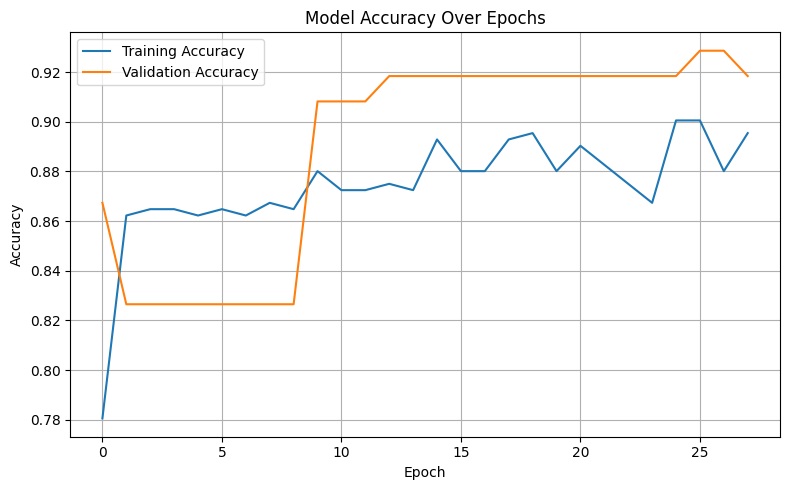

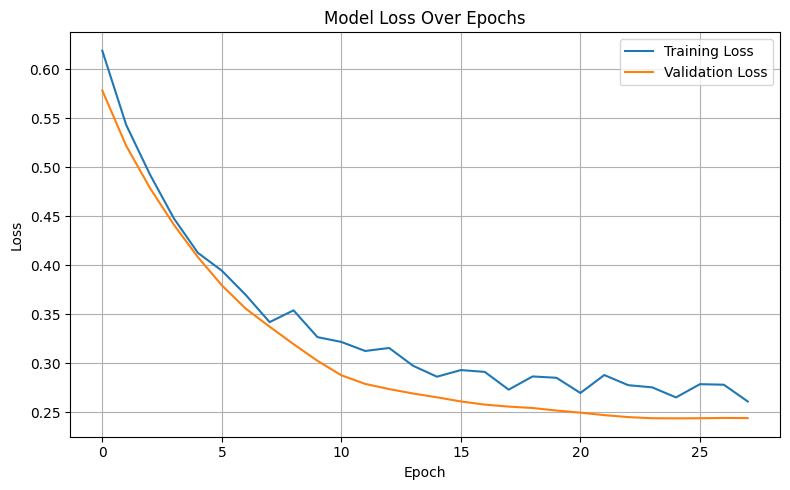

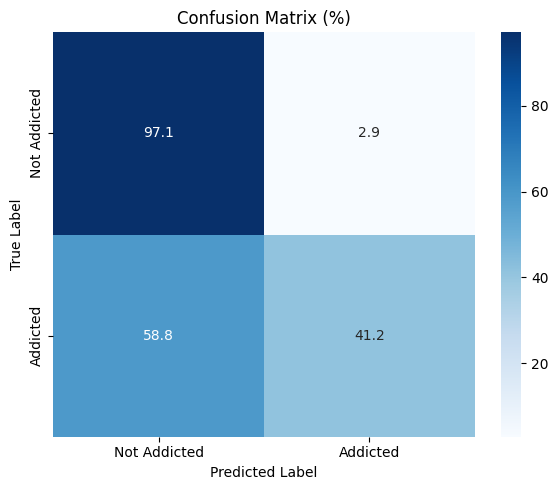

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


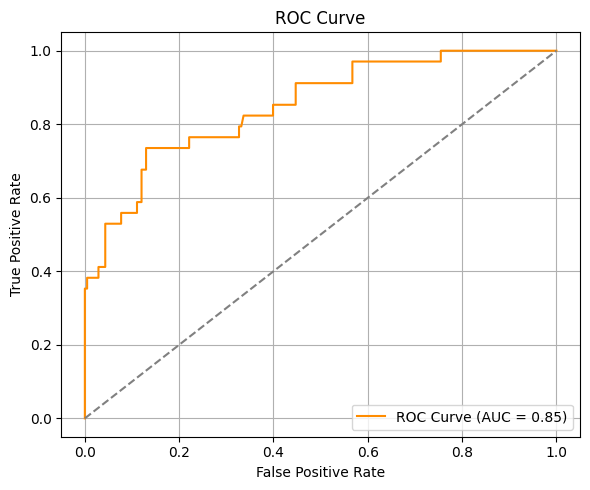

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

#Accuracy (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Loss (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#ROC
y_proba = model.predict(X_test).ravel()  # get raw probabilities
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Potential issues:**
1. Based on train/val accuracy plot, could be overfitting around epoch 26??
2. About half of addicted users end up labelled as not addicted (FALSE NEGATIVE)

**Attempt 1**

Repeat previous neural network, but lower the threshold of y_pred to 0.3 (makes the model more likely to predict "addicted")

Epoch 1/50


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/1257209645.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_daily_activity["Active_Hours"].fillna(0, inplace=True)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layer

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4357 - loss: 0.7226 - val_accuracy: 0.8265 - val_loss: 0.6632
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7407 - loss: 0.6501 - val_accuracy: 0.8265 - val_loss: 0.6092
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8586 - loss: 0.5844 - val_accuracy: 0.8265 - val_loss: 0.5613
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8401 - loss: 0.5543 - val_accuracy: 0.8265 - val_loss: 0.5204
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8606 - loss: 0.5065 - val_accuracy: 0.8265 - val_loss: 0.4828
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8683 - loss: 0.4605 - val_accuracy: 0.8265 - val_loss: 0.4506
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8592 - loss: 0.4248 - val_accuracy: 0.8265 - val_loss: 0.4205
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8661 - loss: 0.3925 - val_accuracy: 0.8265 - val_loss: 0.3932
Epoch 9/50
7/7 ━━━

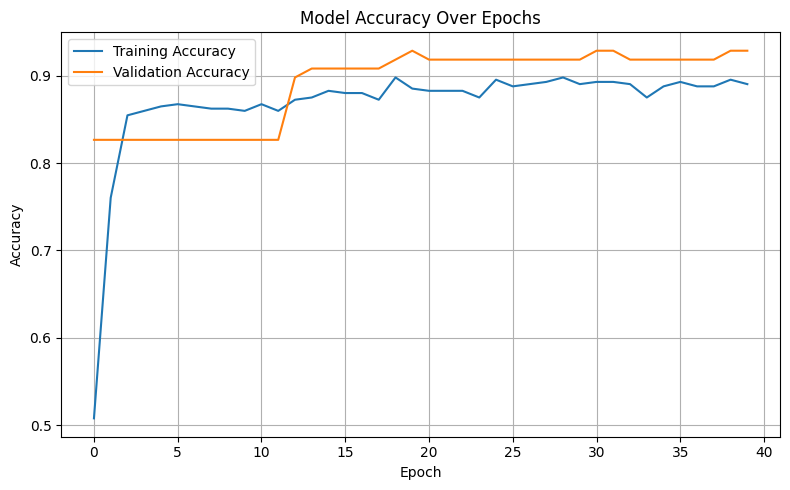

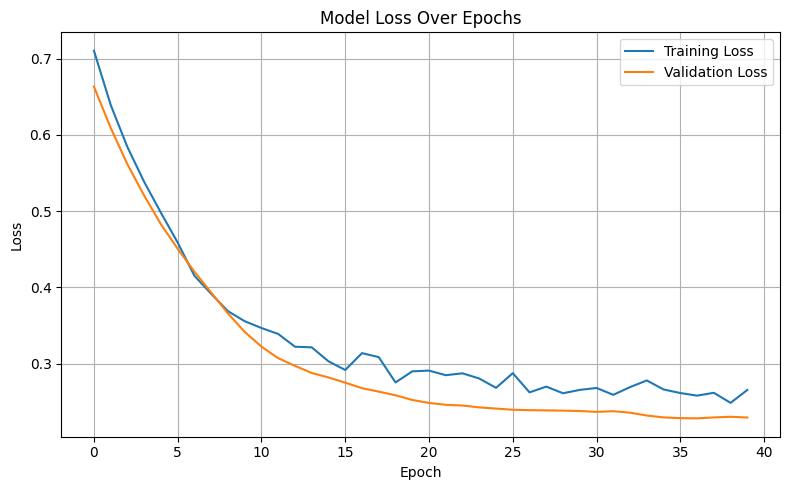

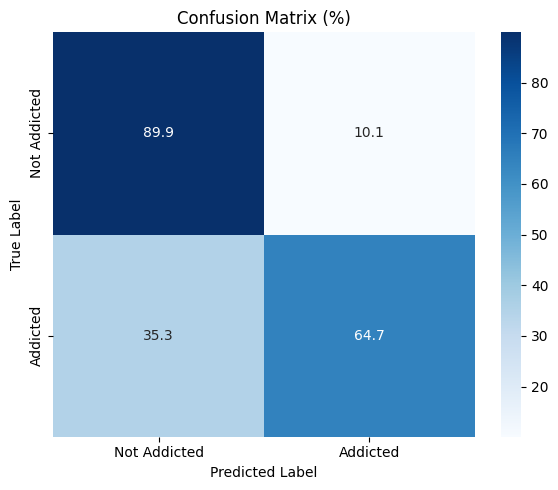

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


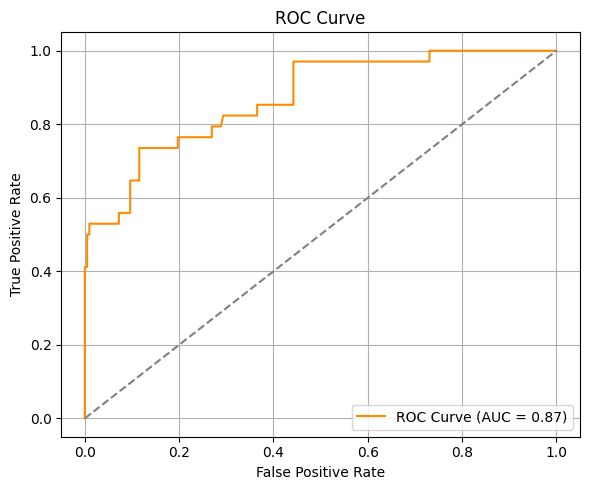

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import parallel_backend
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

#load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),  
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),  
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

#'addicted' label if more than 2 hours OR 100 interactions
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | 
                                   (user_daily_activity["Total_Interactions"] > 100)).astype(int)

#merge
df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)

#Encode sentiment
df["sentiment_num"] = pd.factorize(df["Sentiment"])[0]

# --- 3. Prepare features and target ---
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

#Parallel Scaling (using Joblib for multi-core CPU usage)
scaler = StandardScaler()
with parallel_backend('threading', n_jobs=-1):
    X_scaled = scaler.fit_transform(X)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

#neural network!
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#training w/ early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#evalute
y_pred = (model.predict(X_test) > 0.3).astype(int)

print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Accuracy (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Loss (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#ROC
y_proba = model.predict(X_test).ravel()  # get raw probabilities
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Attempt 2**

Overfitting could be causing this persistent issue in false negatives. Implement dropout and batch normalization to combat that. Also, keep the threshhold at 0.3 since the model is more likely to predict "addicted"

Epoch 1/50


/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5133 - loss: 0.8943 - val_accuracy: 0.6837 - val_loss: 0.6586
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6226 - loss: 0.7252 - val_accuracy: 0.7857 - val_loss: 0.6423
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6374 - loss: 0.7176 - val_accuracy: 0.8163 - val_loss: 0.6293
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6243 - loss: 0.7561 - val_accuracy: 0.8163 - val_loss: 0.6164
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6595 - loss: 0.6245 - val_accuracy: 0.8265 - val_loss: 0.6010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7352 - loss: 0.5814 - val_accuracy: 0.8265 - val_loss: 0.5843
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7106 - loss: 0.5823 - val_accuracy: 0.8469 - val_loss: 0.5712
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6866 - loss: 0.6288 - val_accuracy: 0.8673 - val_loss: 0.5600
Epoch 9/50
7/7 ━━

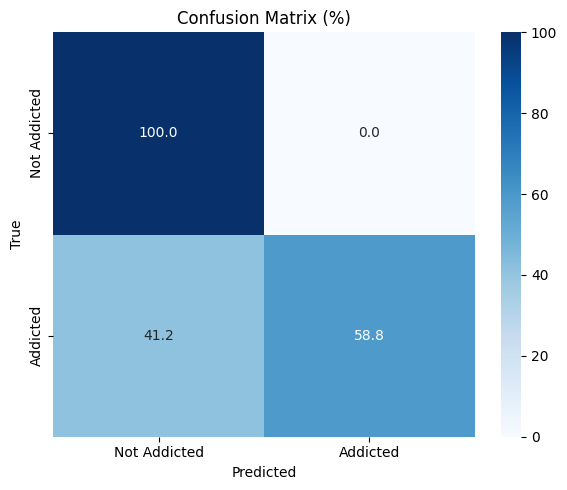

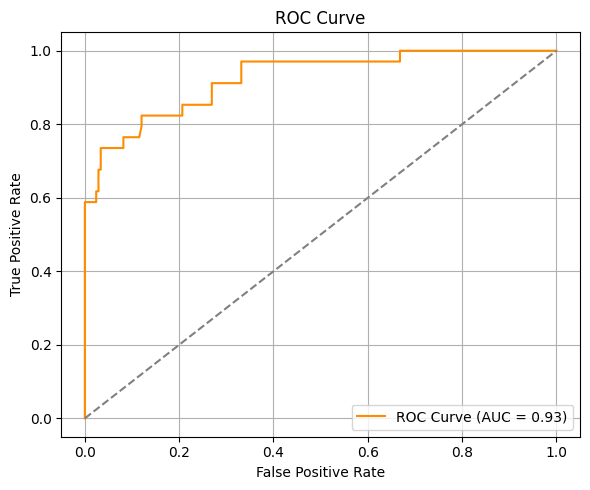

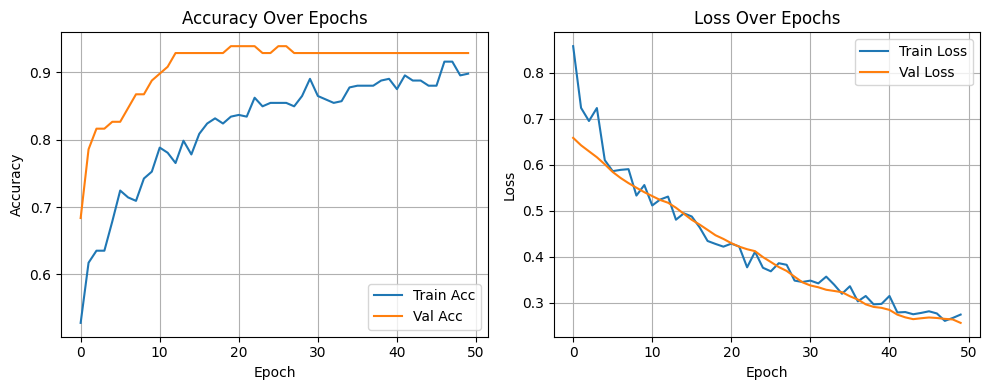

In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

user_daily_activity["Addicted"] = (
    (user_daily_activity["Daily_Usage_Time"] > 2) |
    (user_daily_activity["Total_Interactions"] > 100)
).astype(int)

df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)
df['sentiment_num'] = pd.factorize(df['Sentiment'])[0]

#features and target
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42)

#model with BATCH NORM AND DROPOUT
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#predict
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.3).astype(int)

#results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

#ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#Accuracy/Loss over epochs
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Some improvement**

We now have 100% accuracy treu positives. Yay! However, we still have around 59% accuracy for true negatives. The model seems much more likely to classify as addicted (but still sometimes classifies as 'not addicted').

I still want to try to resolve this false negative issue, so next let's implement class imbalances. Also, let's double check the training data to understand if a class imbalance is causing the issue. Is the model possibly being trained on mostly "addicted" data? If no, we should try over/undersampling and shuffling the data.

/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/1634170969.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='pastel')


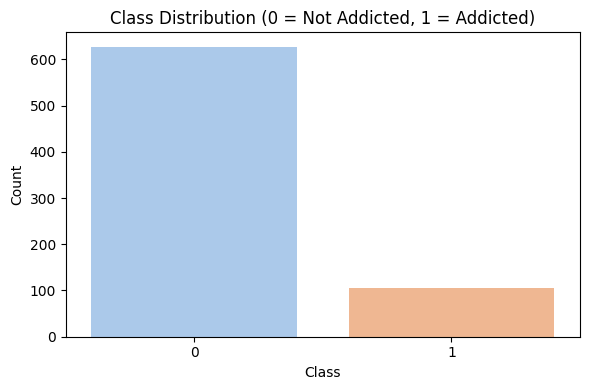

Class Weights: {np.int64(0): np.float64(0.5847255369928401), np.int64(1): np.float64(3.4507042253521125)}
Epoch 1/50


/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5345 - loss: 0.7600 - val_accuracy: 0.8673 - val_loss: 0.6193
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5350 - loss: 0.6278 - val_accuracy: 0.9082 - val_loss: 0.6052
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6081 - loss: 0.5492 - val_accuracy: 0.8980 - val_loss: 0.5957
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5974 - loss: 0.5801 - val_accuracy: 0.8878 - val_loss: 0.5889
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6229 - loss: 0.5786 - val_accuracy: 0.8980 - val_loss: 0.5841
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6283 - loss: 0.5399 - val_accuracy: 0.8878 - val_loss: 0.5778
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6883 - loss: 0.4724 - val_accuracy: 0.9082 - val_loss: 0.5680
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7002 - loss: 0.4965 - val_accuracy: 0.8878 - val_loss: 0.5643
Epoch 9/50
7/7 ━━━

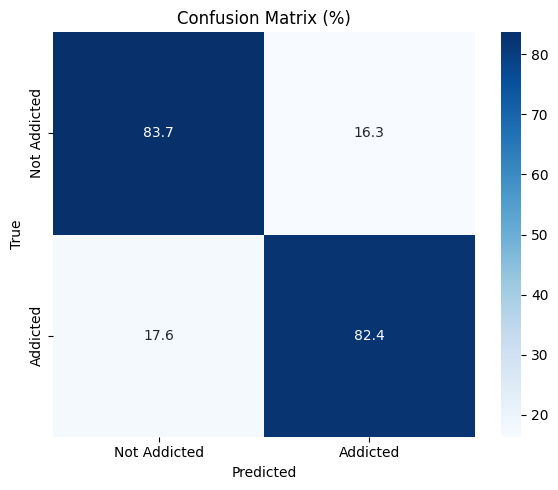

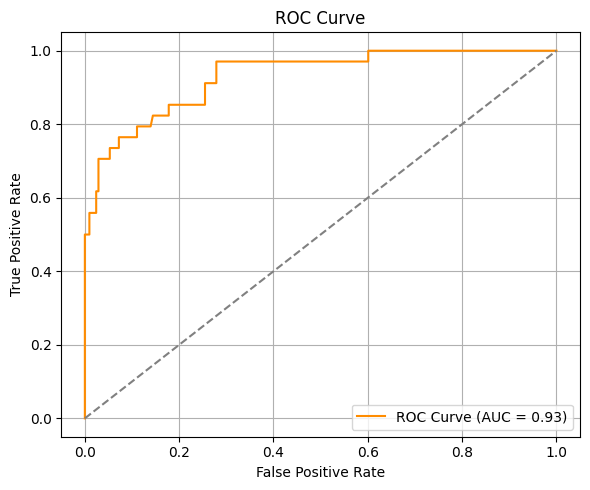

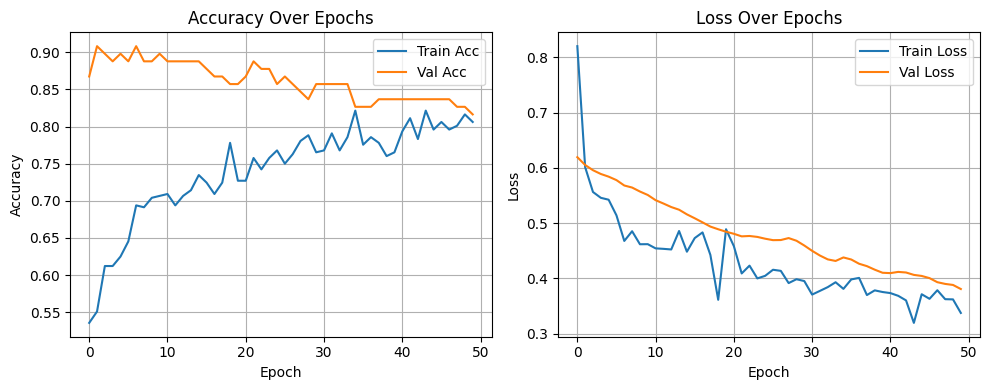

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

user_daily_activity["Addicted"] = (
    (user_daily_activity["Daily_Usage_Time"] > 2) |
    (user_daily_activity["Total_Interactions"] > 100)
).astype(int)

df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)
df['sentiment_num'] = pd.factorize(df['Sentiment'])[0]

#features and target
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

#visualize classes
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='pastel')
plt.title("Class Distribution (0 = Not Addicted, 1 = Addicted)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# scale and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42)

#CLASS WEIGHTS
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

#model with BATCH NORM and DROPOUT
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train model w/ class weights
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

# predict
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

#results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Now what?**

This is the best result yet! I moved the threshhold back to 0.5 (since this is actually what the model SHOULD be doing) and the class imbalance made false negatives account for only ~30% of 'not addicted' data. Also, visualizing the data helped to understand what could be causing this issue. There's far less data training on class 1 (addicted). Let's try over/undersampling to fix this issue. Let's oversample the 'addicted' class (~100 addicted vs. ~600 not addictd)

In [6]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/3996464440.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='pastel')


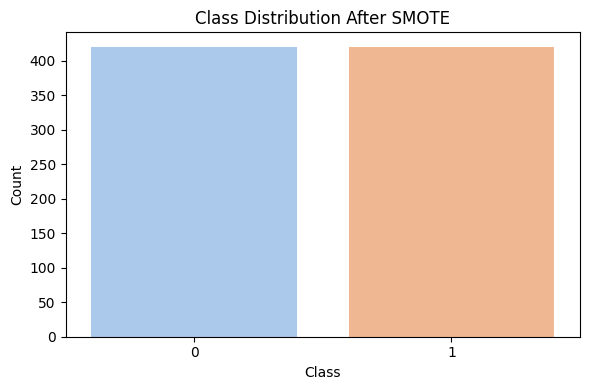

In [7]:
from imblearn.over_sampling import SMOTE

#scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train/Test Split FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42, stratify=y)

# SMOTE for Training Set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled, palette='pastel')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/3363810100.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='pastel')


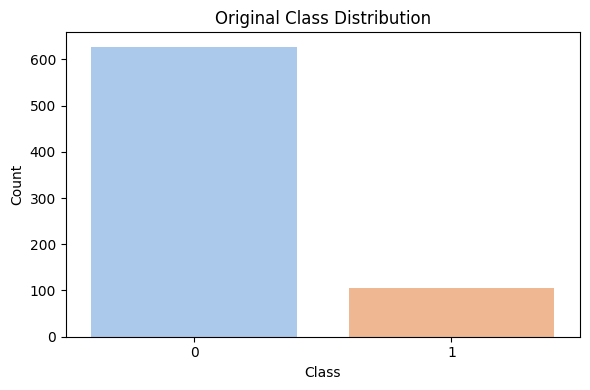

/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_18737/3363810100.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='Set2')


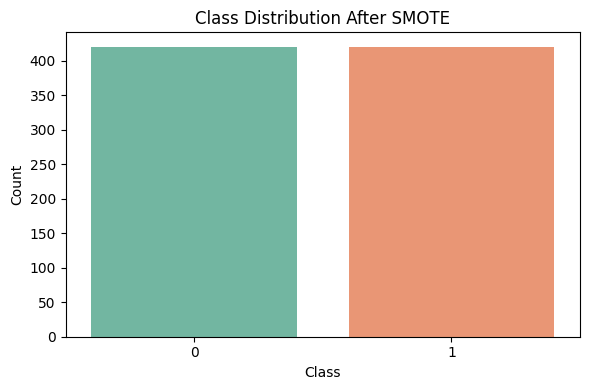

/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7026 - loss: 0.5815 - val_accuracy: 0.6071 - val_loss: 0.5538
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7534 - loss: 0.4870 - val_accuracy: 0.5655 - val_loss: 0.5492
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7908 - loss: 0.4089 - val_accuracy: 0.5655 - val_loss: 0.5569
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8170 - loss: 0.4023 - val_accuracy: 0.5655 - val_loss: 0.5738
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8232 - loss: 0.3567 - val_accuracy: 0.5655 - val_loss: 0.5951
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8417 - loss: 0.3221 - val_accuracy: 0.5595 - val_loss: 0.6266
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8545 - loss: 0.3455 - val_accuracy: 0.5536 - val_loss: 0.6615
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.7768595041322314
Precision: 0.3137254901960784
Recall: 0.4571428571

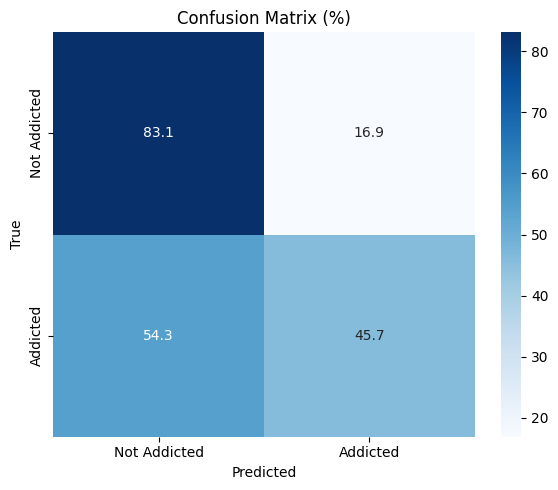

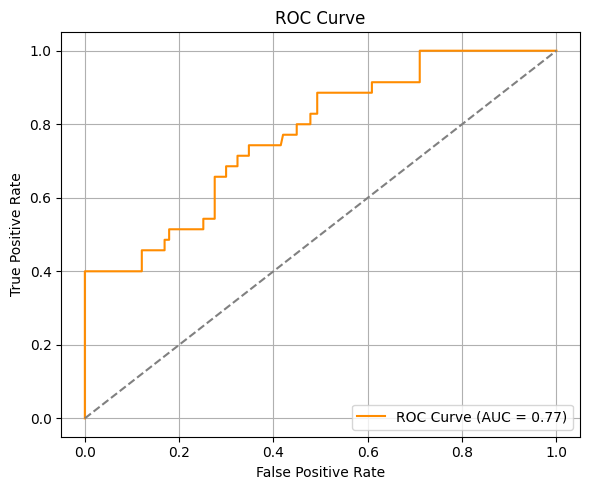

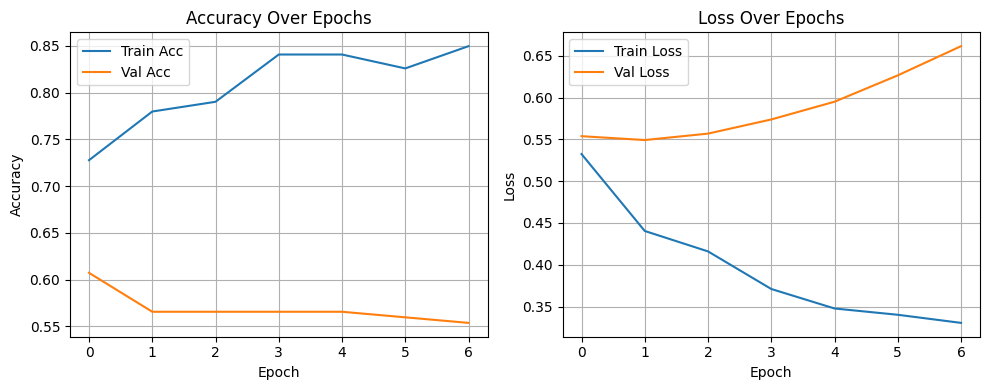

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

user_daily_activity["Addicted"] = (
    (user_daily_activity["Daily_Usage_Time"] > 2) |
    (user_daily_activity["Total_Interactions"] > 100)
).astype(int)

df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)
df['sentiment_num'] = pd.factorize(df['Sentiment'])[0]

#feature and target
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

#visualize (class imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='pastel')
plt.title("Original Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42, stratify=y)

# SMOTE oversampling on training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# class imbalance fixed?
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled, palette='Set2')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#predict
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)  # tuned threshold

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Issues**

train/val accuracy and train/val loss graphs show this model is not performing very well. Also, majoring false negatives now in addicted class. This is worse than it was before. Also, our precision is around 23%. 

Best performance overall was no oversampling, implementing dropout/batch norm/class imbalance.

**Future work**

1. Address class imbalance, improve sampling technique, fine tune further to minimize false negs. 
2. Compare nn runtime CPU (~3 sec) vs GPU (markov, tbd)

**Running on Markov GPU**

Screenshots of output and job.slurm file so everyone has it. I just ran the neural network code from the In [34] cell

**Slurm Script**

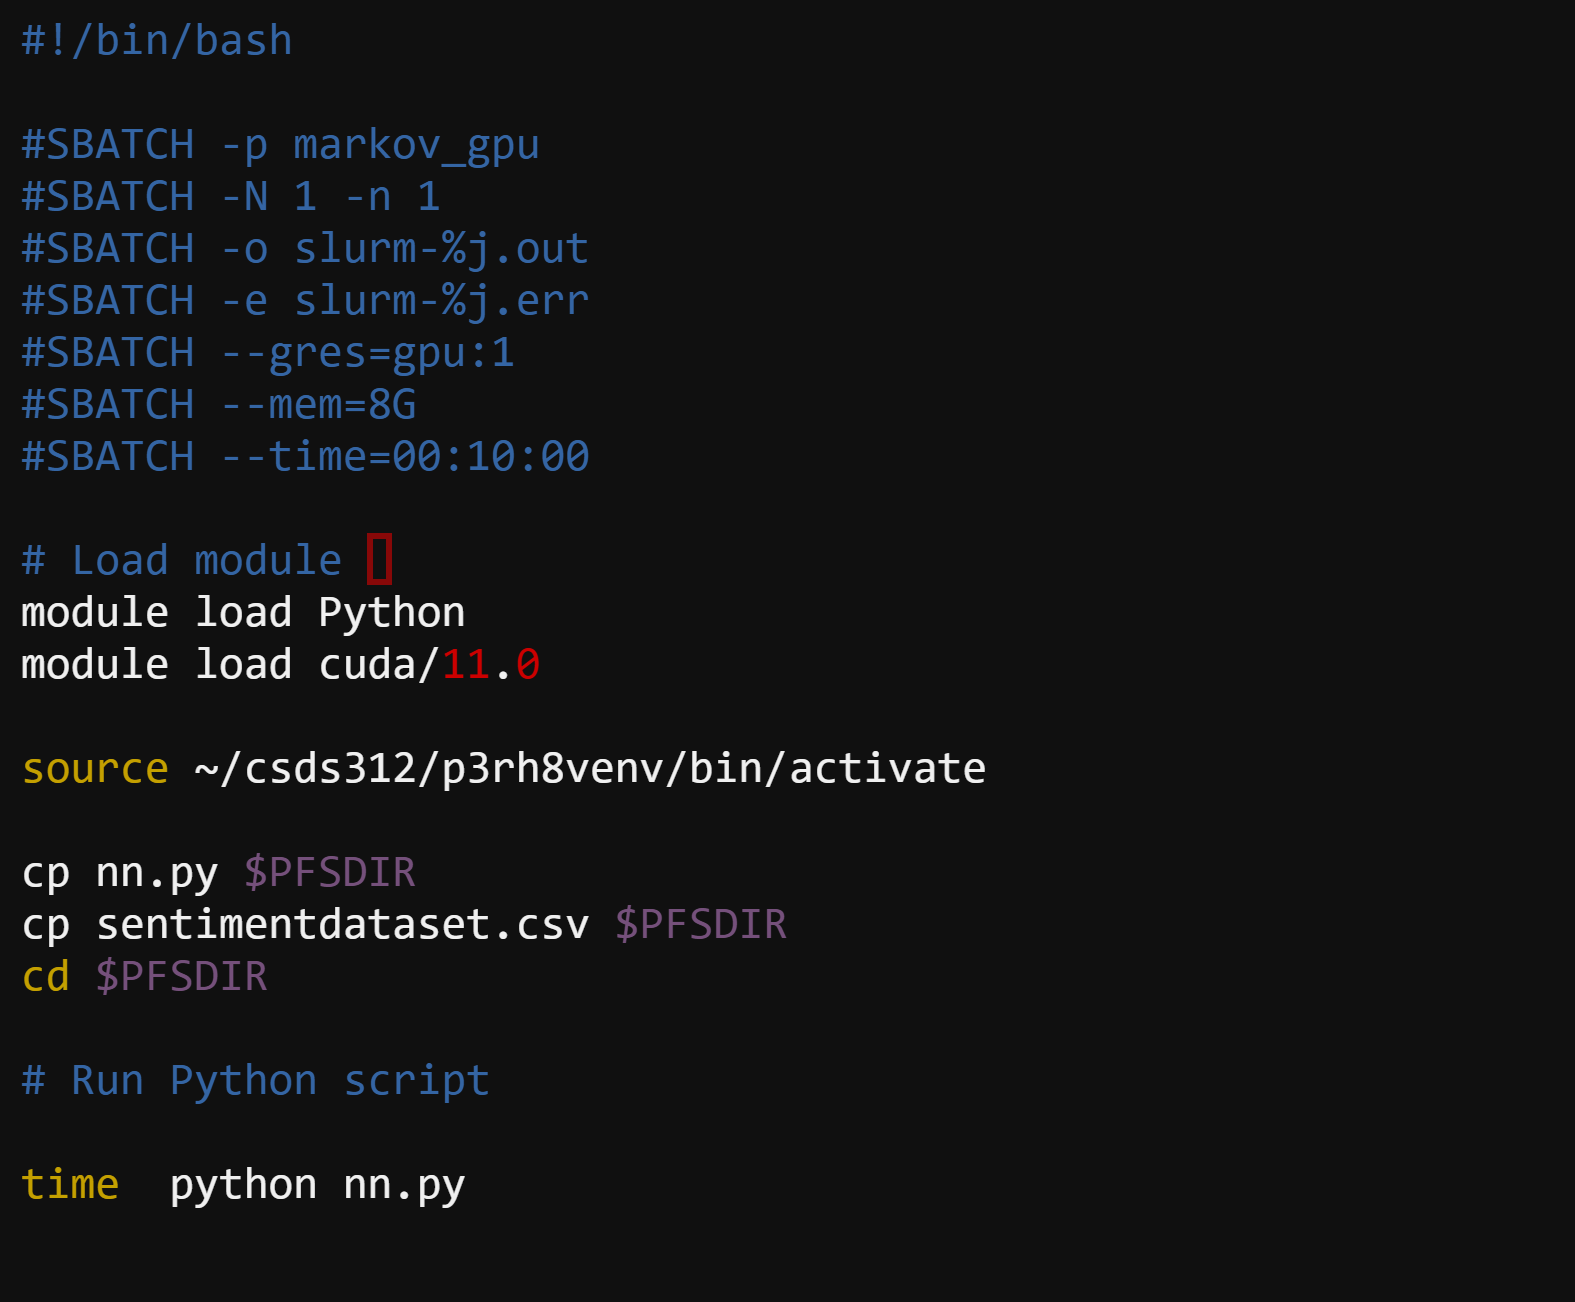

**Output**

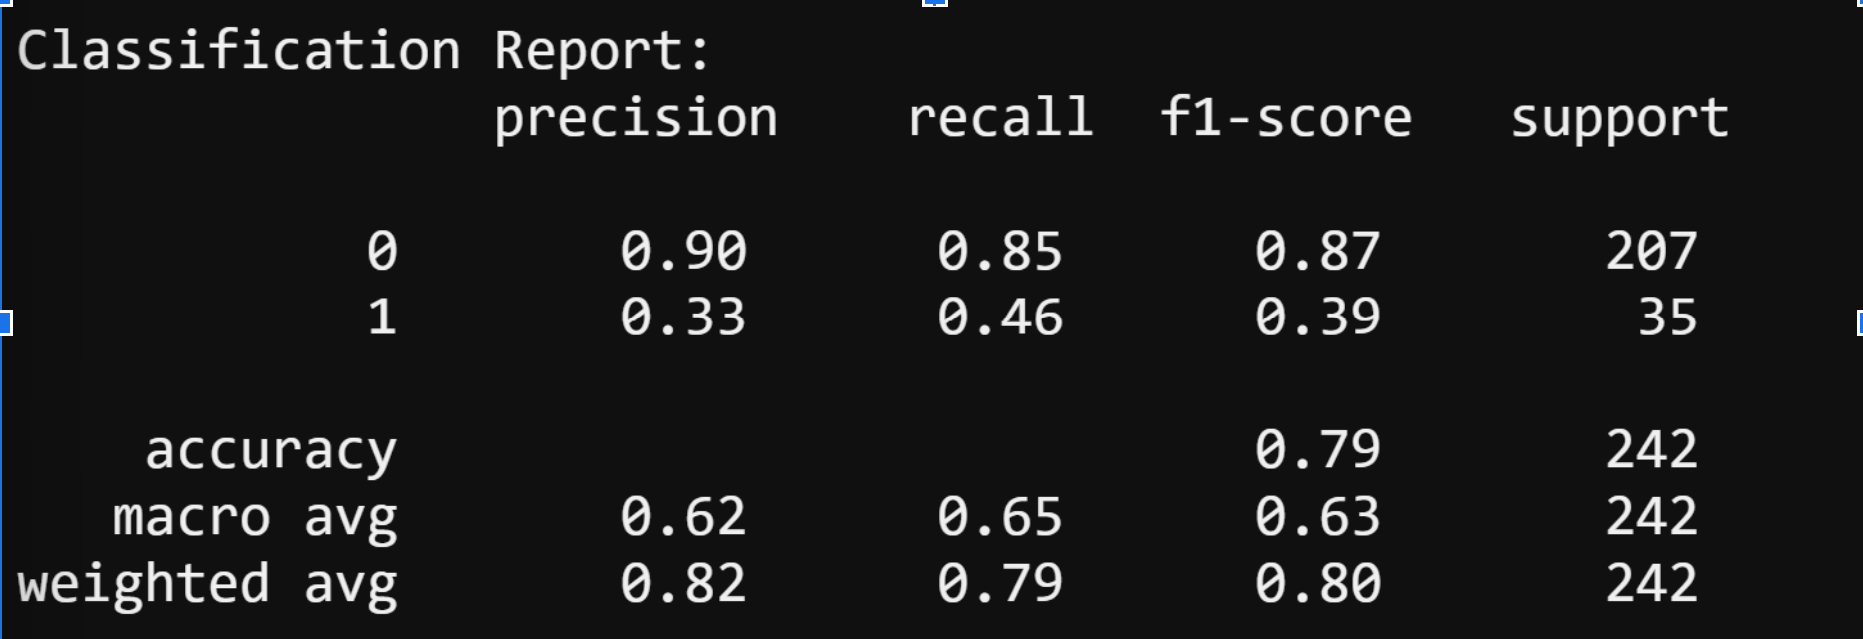

**Performance**
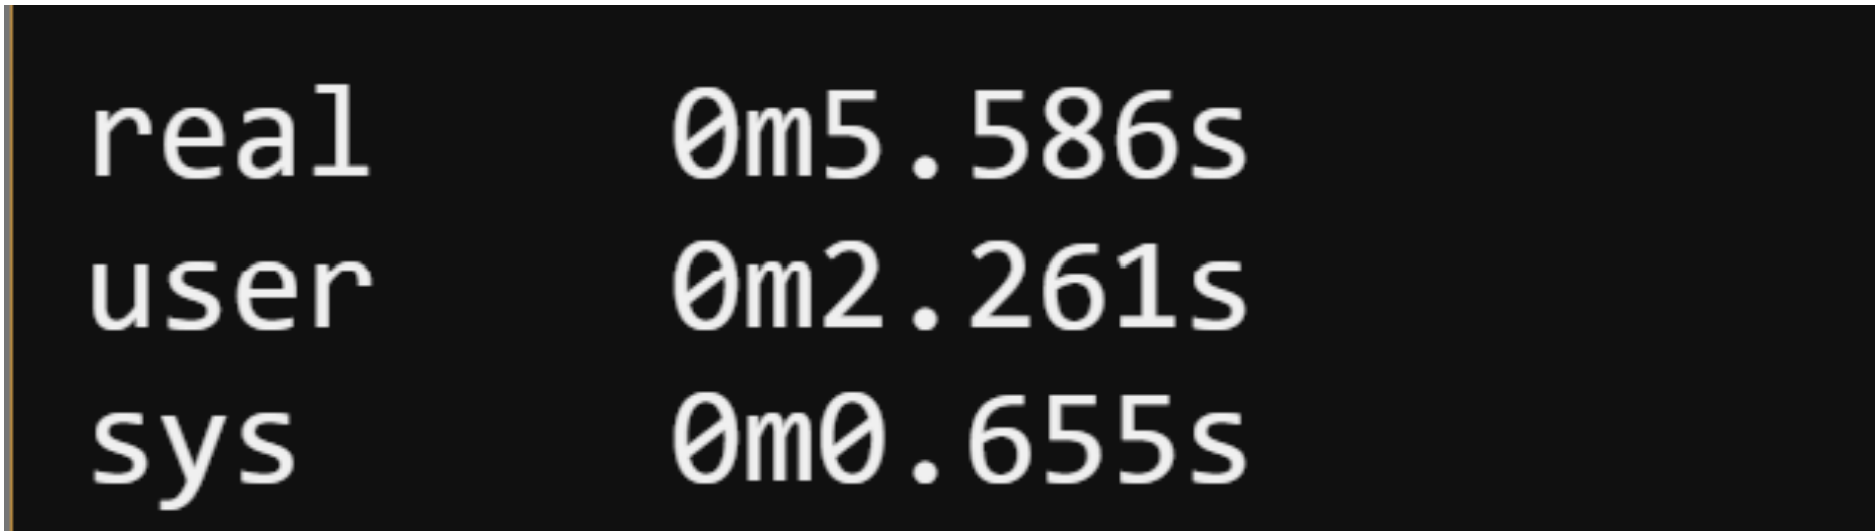

In [21]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,877 (30.77 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 5,124 (20.02 KB)